# Figures for FairCal based on Salvador et al., 2022

### Figures Reproduced

1. Violin plots (Distribution of cosine similarity scores for genuine and imposter pairs, by subgroup)
2. Fairness plots (Global FPR vs Subgroup-specific FPR)

### Imports

In [1]:
!pip install cvxpy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
import pickle
import sys
from csv_creator import create_rfw_csv_template, create_similarity_data

### Loading cosine similarities (settings: rfw, facenet-webface, beta calibration)

In [3]:
# Uncomment and run in case the the user does not have the csv files with cosine similarities
# create_rfw_csv_template()
# create_similarity_data()

In [4]:
db = pd.read_csv('data/rfw/rfw_w_sims.csv')
dataset_name = 'rfw'
feature = 'facenet-webface'
calibration_method = 'beta'
nbins = 10
n_clusters = 100

In [5]:
subgroups = {'ethnicity': ['African', 'Asian', 'Caucasian', 'Indian']}
sensitive_attributes = {'ethnicity': ['ethnicity', 'ethnicity']}
fold = 5

In [6]:
features = ['facenet-webface']

In [7]:
db_fold = {'cal': db[db['fold'] != fold], 'test': db[db['fold'] == fold]}

### Getting dictionaries for cosine similarities (float), confidence scores (empty), ground truth labels (boolean) and subgroup scores (ethnicity)

In [8]:
scores = {}
confidences = {}
for feature in features:
    scores[feature] = {}
    confidences[feature] = {}
ground_truth = {}
subgroup_scores = {}
for dataset in ['cal', 'test']:
    for feature in features:
        scores[feature][dataset] = np.array(db_fold[dataset][feature])
    ground_truth[dataset] = np.array(db_fold[dataset]['same'])
    subgroup_scores[dataset] = {}
    for att in subgroups.keys():
        subgroup_scores[dataset][att] = {}
        subgroup_scores[dataset][att]['left'] = np.array(db_fold[dataset][sensitive_attributes[att][0]])
        subgroup_scores[dataset][att]['right'] = np.array(db_fold[dataset][sensitive_attributes[att][1]])

In [9]:
print(f'Cosine sims: {scores}\n')
print(f'Confidences: {confidences}\n')
print(f'Ground truth: {ground_truth}\n')
print(f'Subgroup scores: {subgroup_scores}\n')

Cosine sims: {'facenet-webface': {'cal': array([0.61013806, 0.53673297, 0.63101548, ..., 0.34438381, 0.24821165,
       0.24586767]), 'test': array([0.42275068, 0.39303565, 0.60942829, ..., 0.40219867, 0.37166822,
       0.06538376])}}

Confidences: {'facenet-webface': {}}

Ground truth: {'cal': array([ True,  True,  True, ..., False, False, False]), 'test': array([ True,  True,  True, ..., False, False, False])}

Subgroup scores: {'cal': {'ethnicity': {'left': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object), 'right': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object)}}, 'test': {'ethnicity': {'left': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object), 'right': array(['African', 'African', 'African', ..., 'Indian', 'Indian', 'Indian'],
      dtype=object)}}}



### Checking the size of the entries

In [10]:
print('Cosine similarity:', end = ' ')
print(len(scores[feature]['cal']), end = ' (cal), ')
print(len(scores[feature]['test']), end = ' (test)\n')

print('Ground truth:', end = ' ')
print(len(ground_truth['cal']), end = ' (cal), ')
print(len(ground_truth['test']), end = ' (test)\n')

print('Subgroup scores:', end = ' ')
print(len(subgroup_scores['cal']['ethnicity']['left']), end = ' (left), ')
print(len(subgroup_scores['cal']['ethnicity']['right']), end = ' (right)')

Cosine similarity: 21596 (cal), 2398 (test)
Ground truth: 21596 (cal), 2398 (test)
Subgroup scores: 21596 (left), 21596 (right)

### Drop missing values

In [11]:
indices_to_keep = {'cal': np.isnan(scores[feature]['cal']) == False,
                  'test': np.isnan(scores[feature]['test']) == False
                  }

for dataset in indices_to_keep:
    indices = indices_to_keep[dataset]
    
    scores[feature][dataset] = scores[feature][dataset][indices]
    ground_truth[dataset] = ground_truth[dataset][indices]
    subgroup_scores[dataset]['ethnicity']['left'] = subgroup_scores[dataset]['ethnicity']['left'][indices]
    subgroup_scores[dataset]['ethnicity']['right'] = subgroup_scores[dataset]['ethnicity']['right'][indices]
    
    db_fold[dataset] = db_fold[dataset].iloc[indices]

### Loading the embeddings

In [12]:
embedding_data = pickle.load(open(f'embeddings/{feature}_{dataset_name}_embeddings.pk', 'rb'))

if dataset_name == 'bfw':
    embedding_data['img_path'] = embedding_data['img_path'].apply(lambda x: x.replace('data/bfw/bfw-cropped-aligned/', ''))
if dataset_name == 'rfw':
    embedding_data['img_path'] = embedding_data['img_path'].apply(lambda x: x.replace('data/rfw/data/', ''))

### Calculating confidence scores

In [13]:
from fairness_analyzer import RfwFairnessAnalyzer

In [14]:
approach_name = ['baseline', 'fsn', 'oracle', 'faircal', 'faircal-gmm']

n_cluster=100
fpr_thr=1e-3
feature='facenet-webface'
calibration_method='beta'

for approach in approach_name:
    print(approach)
    if approach != 'faircal-gmm':
        fa = RfwFairnessAnalyzer(n_cluster=n_cluster, fpr_thr=fpr_thr, feature=feature, approach=approach, calibration_method=calibration_method)
        _, _, confidences[feature][approach], _ = fa.get_metrics(embedding_data, db_fold, fold, scores[feature], ground_truth, subgroup_scores)
    
    else:
        path = '/Users/milenakapralova/Documents/FACT/faircal/code/experiments/clustering_faircal-gmm/rfw_facenet-webface_nclusters100_fold5.npy'
        clusters = np.load(path, allow_pickle=True).item()
        score_normalization = False
        fpr = 0
        _, _, confidences[feature]['faircal-gmm'], cluster_settings = fa.cluster_methods(
                    fold, 
                    db_fold, 
                    score_normalization,
                    fpr, 
                    embedding_data,
                    saved_clusters = clusters
                )


baseline
fsn


Running initialization...


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Fitting K-Means...


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Statistics Cluster K = 100
Minimum number of pairs in clusters 234
Maximum number of pairs in clusters 497
Median number of pairs in clusters 389.0
Mean number of pairs in clusters 382.7
oracle
faircal


Running initialization...


Training: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Fitting K-Means...


Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Statistics Cluster K = 100
Minimum number of pairs in clusters 257
Maximum number of pairs in clusters 534
Median number of pairs in clusters 371.0
Mean number of pairs in clusters 381.8
faircal-gmm


Predicting: 0it [00:00, ?it/s]

Statistics Cluster K = 100
Minimum number of pairs in clusters 227
Maximum number of pairs in clusters 574
Median number of pairs in clusters 380.5
Mean number of pairs in clusters 382.9


In [15]:
for approach in confidences['facenet-webface'].keys():
    db_fold['test'][approach] = confidences[feature][approach]['test'] if approach != 'oracle' else confidences[feature][approach]['test']['ethnicity']

### Plotting

In [16]:
db_fold['test']['pair'] = db_fold['test']['pair'].replace('Ungenuine', 'Imposter')

In [17]:
subgroups = ['African', 'Asian', 'Caucasian', 'Indian']
title_approaches = ['Baseline', 'Baseline+Calibration', 'FSN', 'Oracle Calibration', 'FairCal', 'FairCal-GMM']
approaches = ['facenet-webface', 'baseline', 'fsn', 'oracle', 'faircal', 'faircal-gmm']

In [18]:
def plot_by_approach(type_plot, subgroups, title_approaches, approaches, resid=False):    
    legend_fontsize = 18
    title_fontsize = 24
    label_fontsize = 20
    ticks_fontsize = 18

    fig, axes = plt.subplots(1,len(approaches),figsize=(20,5), sharey=True)
    fpr_subgroup = {}
    
    # Violin plots (Distribution of cosine similarity scores for genuine and imposter pairs, by subgroup)
    if type_plot == 'violin':
        my_pal = {"Genuine": "seagreen", "Imposter": "lightgreen"}
        
        for i_approach, approach in enumerate(approaches):
            sns.violinplot(
            x ='ethnicity',
            hue="pair",
            y=approach,
            split=True,
            data=db_fold['test'],
            scale="count",
            inner="quartile",
            ax = axes[i_approach],
            order=subgroups,
            palette=my_pal
        )
            axes[i_approach].legend(loc = 'lower right', fontsize=legend_fontsize)
            axes[i_approach].set_xlabel('Ethnicity', fontsize=label_fontsize)
            axes[i_approach].set_title(title_approaches[i_approach], fontsize=title_fontsize)
            if approach == 'facenet-webface':
                axes[i_approach].set_ylabel('Cosine Similarity Score', fontsize=label_fontsize)
            else:
                axes[i_approach].set_ylabel('Probability', fontsize=label_fontsize)
            labels = [item.get_text() for item in axes[i_approach].get_yticklabels()]
            empty_string_labels = ['']*len(labels)
            axes[i_approach].set_yticklabels(empty_string_labels)

            axes[i_approach].tick_params(axis='x', labelsize=ticks_fontsize-2)

            global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
                    y_true = ground_truth['test'],
                    y_score = db_fold['test'][approach],
                    drop_intermediate=False,
                    pos_label = True)

            axes[i_approach].axhline(global_thr[np.argmin(np.abs(global_fpr-0.05))],
                            ls='-',
                            linewidth=2,
                            alpha = 1,
                            c='black')
            fpr_subgroup[approach] = {}
            for j, subgroup in enumerate(subgroups):
                select = subgroup_scores['test']['ethnicity']['left'] == subgroup
                fpr,tpr,thr = sklearn.metrics.roc_curve(
                    y_true = ground_truth['test'][select],
                    y_score = db_fold['test'][approach][select],
                    drop_intermediate=False,
                    pos_label = True)
                axes[i_approach].hlines(y = thr[np.argmin(np.abs(fpr-0.05))],
                               ls='-',
                               color='crimson',
                               linewidth=3,
                               xmin =j-0.5,
                               xmax = j+1-0.5)
                fpr_subgroup[approach][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
                print("%s - %s FPR = %1.3f"%(title_approaches[i_approach], subgroup, fpr_subgroup[approach][j]))
                
    # Fairness plots (Global FPR vs Subgroup-specific FPR)
    elif type_plot == 'fairness' and not resid:
        for i_approach, approach in enumerate(approaches):
            global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
                    y_true = ground_truth['test'],
                    y_score = db_fold['test'][approach],
                    drop_intermediate=False,
                    pos_label = True)
            fpr_subgroup[approach] = np.zeros(len(subgroups))
            for j, subgroup in enumerate(subgroups):
                select = subgroup_scores['test']['ethnicity']['left'] == subgroup
                fpr,tpr,thr = sklearn.metrics.roc_curve(
                    y_true = ground_truth['test'][select],
                    y_score = db_fold['test'][approach][select],
                    drop_intermediate=False,
                    pos_label = True)
                axes[i_approach].plot(np.interp(thr,global_thr[::-1],global_fpr[::-1]),fpr, linewidth=2)
                fpr_subgroup[approach][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
                print('%s %s - %1.1f'%(title_approaches[i_approach],subgroup, fpr_subgroup[approach][j]))
            axes[i_approach].plot([0.05, 0.05],[0,1],'--k',linewidth=2)
            axes[i_approach].legend(subgroups,loc = 'upper left')
            axes[i_approach].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
            axes[i_approach].set_xlim(0,0.1)
            axes[i_approach].set_ylim(0,0.18)
            axes[i_approach].set_title(title_approaches[i_approach], fontsize=title_fontsize)
            axes[i_approach].set_xlabel('Global FPR', fontsize=title_fontsize)
            if i_approach == 0:
                axes[i_approach].set_ylabel('False Positive Rate', fontsize=title_fontsize)
            axes[i_approach].tick_params(axis='both', which='major', labelsize=ticks_fontsize)
                
    # Fairness plots (Global FPR vs Subgroup-specific FPR) with residuals            
    elif type_plot == 'fairness' and resid:
        for i_approach, approach in enumerate(approaches):
            global_fpr,global_tpr,global_thr = sklearn.metrics.roc_curve(
                    y_true = ground_truth['test'],
                    y_score = db_fold['test'][approach],
                    drop_intermediate=False,
                    pos_label = True)
            fpr_subgroup[approach] = np.zeros(len(subgroups))
            x = []
            y = []
            for j, subgroup in enumerate(subgroups):
                select = subgroup_scores['test']['ethnicity']['left'] == subgroup
                fpr,tpr,thr = sklearn.metrics.roc_curve(
                    y_true = ground_truth['test'][select],
                    y_score = db_fold['test'][approach][select],
                    drop_intermediate=False,
                    pos_label = True)

                x_current = np.interp(thr,global_thr[::-1],global_fpr[::-1])
                cond = x_current < 0.1       
                x.append(x_current[cond])
                y_current = fpr
                y.append(y_current[cond])
                axes[i_approach].scatter(x_current, y_current, s=4)

                fpr_subgroup[approach][j] = 100*fpr[np.argmin(np.abs(thr-np.interp(0.05,global_fpr,global_thr)))]
            x = np.hstack(x)
            y = np.hstack(y)
            coefs, residual, _, _, _ = np.polyfit(x, y, deg=1, full=True)

            a = coefs[0]
            b = coefs[1]
            y_pred = a * x + b
            axes[i_approach].plot(x, y_pred, color='black', linestyle='-', linewidth=2)
            print(f'{approach.capitalize()} gave the residual = {round(residual[0], 4)}.')
            axes[i_approach].plot([0.05, 0.05],[0,1],'--k',linewidth=2)
            axes[i_approach].legend(subgroups,loc = 'upper left', prop={'size': 17})
            axes[i_approach].set_xticks([0,0.02,0.04,0.06,0.08,0.1])
            axes[i_approach].set_xlim(0,0.1)
            axes[i_approach].set_ylim(0,0.18)
            axes[i_approach].set_title(title_approaches[i_approach], fontsize=title_fontsize)
            axes[i_approach].set_xlabel('Global FPR', fontsize=title_fontsize)
            if i_approach == 0:
                axes[i_approach].set_ylabel('False Positive Rate', fontsize=title_fontsize)
            axes[i_approach].tick_params(axis='both', which='major', labelsize=ticks_fontsize)

    else:
        print('Please specify a valid plot type.')
    
    fig.tight_layout()
    plt.savefig(f'figs_iclr/{feature}_{type_plot}_plot.png', bbox_inches='tight')

#### Violin plots (Distribution of cosine similarity scores for genuine and imposter pairs, by subgroup)

Baseline - African FPR = 5.667
Baseline - Asian FPR = 9.732
Baseline - Caucasian FPR = 0.334
Baseline - Indian FPR = 4.333
Baseline+Calibration - African FPR = 5.667
Baseline+Calibration - Asian FPR = 9.732
Baseline+Calibration - Caucasian FPR = 0.334
Baseline+Calibration - Indian FPR = 4.333
FSN - African FPR = 3.333
FSN - Asian FPR = 6.711
FSN - Caucasian FPR = 4.348
FSN - Indian FPR = 6.000
Oracle Calibration - African FPR = 3.667
Oracle Calibration - Asian FPR = 5.705
Oracle Calibration - Caucasian FPR = 5.686
Oracle Calibration - Indian FPR = 5.000
FairCal - African FPR = 4.333
FairCal - Asian FPR = 6.040
FairCal - Caucasian FPR = 5.017
FairCal - Indian FPR = 5.000
FairCal-GMM - African FPR = 4.667
FairCal-GMM - Asian FPR = 5.369
FairCal-GMM - Caucasian FPR = 5.017
FairCal-GMM - Indian FPR = 5.333


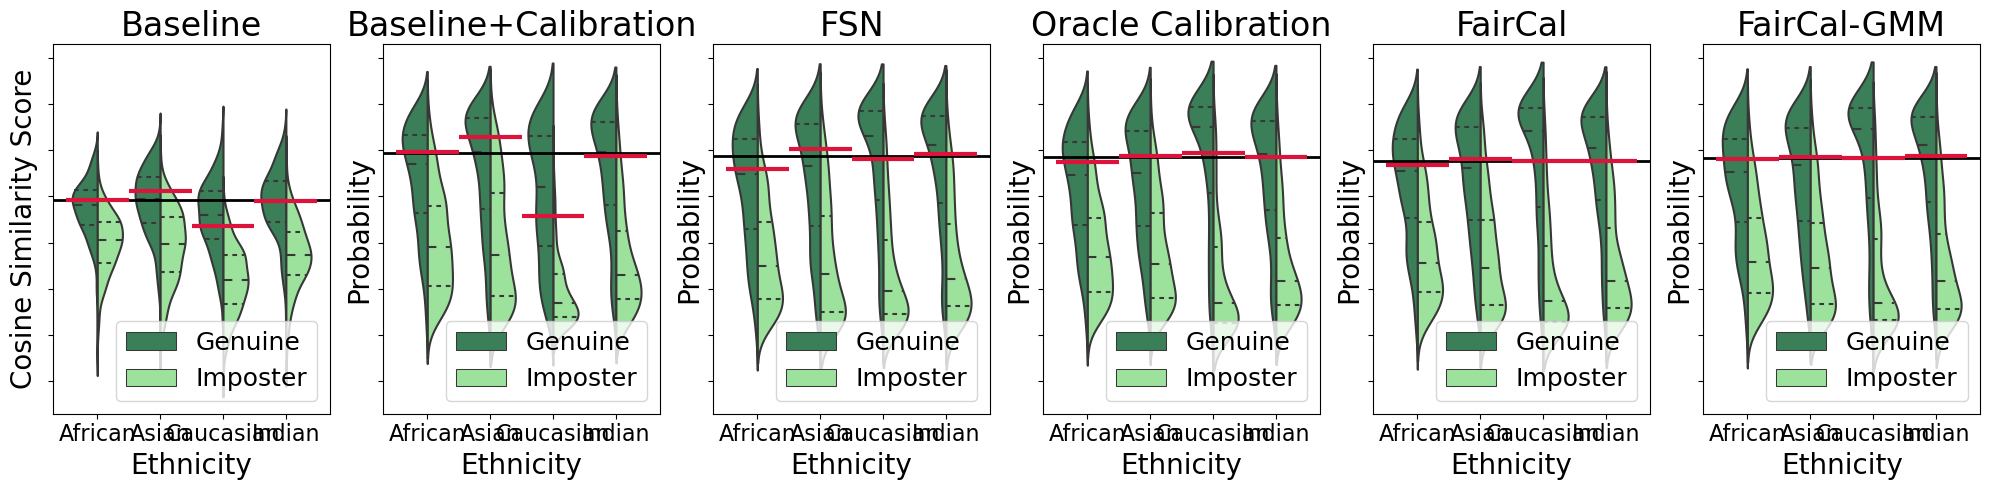

In [19]:
plot_by_approach(type_plot='violin', subgroups=subgroups, title_approaches=title_approaches, approaches=approaches, resid=False)

#### Fairness plots (Global FPR vs Subgroup-specific FPR)

Baseline African - 5.7
Baseline Asian - 9.7
Baseline Caucasian - 0.3
Baseline Indian - 4.3
Baseline+Calibration African - 5.7
Baseline+Calibration Asian - 9.7
Baseline+Calibration Caucasian - 0.3
Baseline+Calibration Indian - 4.3
FSN African - 3.3
FSN Asian - 6.7
FSN Caucasian - 4.3
FSN Indian - 6.0
Oracle Calibration African - 3.7
Oracle Calibration Asian - 5.7
Oracle Calibration Caucasian - 5.7
Oracle Calibration Indian - 5.0
FairCal African - 4.3
FairCal Asian - 6.0
FairCal Caucasian - 5.0
FairCal Indian - 5.0
FairCal-GMM African - 4.7
FairCal-GMM Asian - 5.4
FairCal-GMM Caucasian - 5.0
FairCal-GMM Indian - 5.3


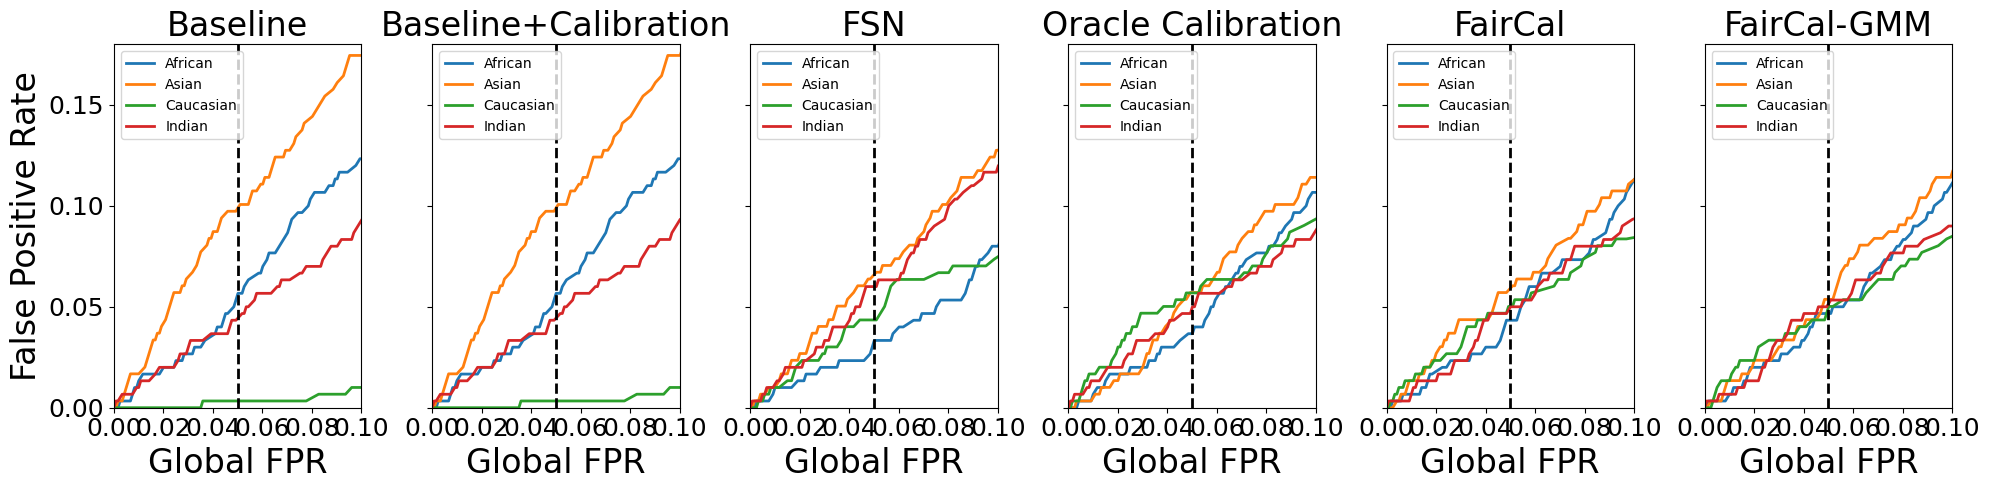

In [20]:
plot_by_approach(type_plot='fairness', subgroups=subgroups, title_approaches=title_approaches, approaches=approaches, resid=False)

#### Fairness plots (Global FPR vs Subgroup-specific FPR) with residuals

Facenet-webface gave the residual = 0.4989.
Baseline gave the residual = 0.4989.
Fsn gave the residual = 0.0903.
Oracle gave the residual = 0.0332.
Faircal gave the residual = 0.0239.
Faircal-gmm gave the residual = 0.0193.


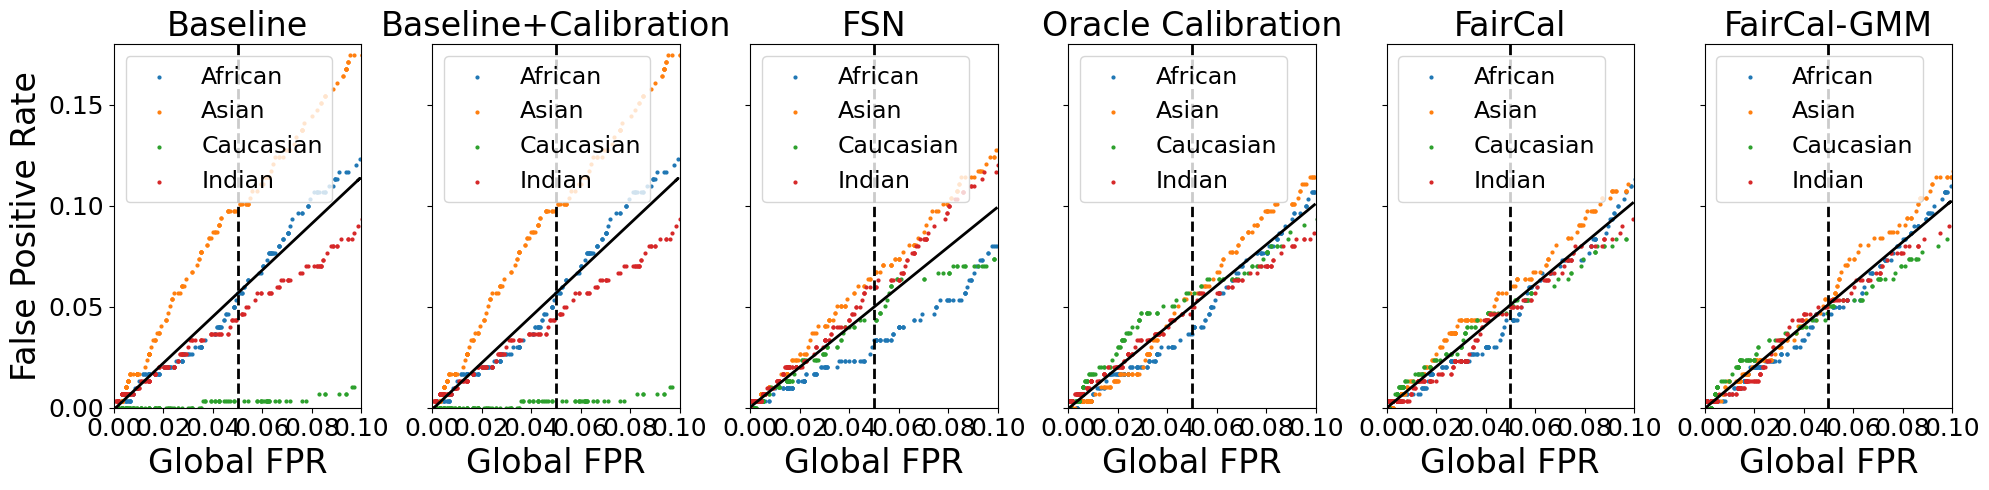

In [21]:
plot_by_approach(type_plot='fairness', subgroups=subgroups, title_approaches=title_approaches, approaches=approaches, resid=True)